# Approximating the largest Lyapunov exponent of the Lorenz system using JAX's autodiff

The Lorenz equations are a prototypical example of **deterministic chaos**. They
are a system of three **nonlinear** ODEs

$$
\begin{aligned}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{aligned}
$$

The three variables can be combined into the state vector $u = (x, y, z) \in
\mathbb{R}^3$. Assume we have an initial condition $u(0)$ and another one
slightly next to it $\tilde{u}(0)$. Hence, their difference is $\delta u(0) =
\tilde{u}(0) - u(0)$. The maximum Lyapunov exponent $\lambda$ describes how
(exponentially) quickly the two trajectories diverge

$$
\| \delta u(t) \| \approx \| \delta u(0) \| \exp(\lambda t).
$$

In this notebook, we will approximate $\lambda$ for the Lorenz system under the
original configuration $\sigma = 10$, $\rho = 28$ and $\beta = 8/3$ (1) using a
[Runge-Kutta 4
simulator](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lorenz_simulator_numpy.ipynb)
of time step size $\Delta t = 0.01$. Let's call the discrete time stepper
$\mathcal{P}$ that advances from one time level $u^{[t]}$ to the next
$u^{[t+1]}$. Then, we can approximate the largest Lyapunov exponent $\lambda$
by

$$
\lambda \approx \frac{1}{T} \sum_{t=0}^{T-1} \log \frac{\|\epsilon^{[t+1]}\|_2}{\|\epsilon^{[t]}\|_2},
$$

in which $\epsilon^{[t]}$ is a perturbation that is integrated alongside the
original trajectory and evolves using the system's Jacobian matrix

$$
\frac{d\epsilon}{dt} = J(u) \epsilon.
$$

Leading to the following strategy:

1. Draw a reasonable initial condition, e.g. $u^{[0]} = (1, 1, 1)$.
2. Evolve the initial condition until it enters the chaotic attractor, e.g., by
   using $5000$ time steps to get $u^{[5000]}$.
3. Use the last state $u^{[5000]}$ as the "warmed-up" initial state $u^{[0]}
   \leftarrow u^{[5000]}$.
4. Introduce a small perturbation $\epsilon^{[0]}$, e.g., using random normal
   noise with $\epsilon_i \propto \mathcal{N}(0, 1)$, and normalize it to get
   $\epsilon^{[0]} \leftarrow \epsilon^{[0]}/\|\epsilon^{[0]}\|_2$.
5. Evolve $u^{[t]}$ via the Runge-Kutta 4 stepper $u^{[t+1]} =
   \mathcal{P}(u^{[t]})$. At the same time, at each time step $t$, compute the
   Jacobian of the time stepper evaluated at the current state
   $J_\mathcal{P}(u^{[t]})$. Then, evolve the perturbation $\epsilon^{[t]}$ via
   the $\epsilon^{[t+1]} = J_\mathcal{P}(u^{[t]}) \epsilon^{[t]}$. Re-normalize
   $\epsilon^{[t+1]} \leftarrow \epsilon^{[t+1]}/\|\epsilon^{[t+1]}\|_2$
   afterwards. (*)
6. Do this for a certain number of time steps, e.g. $50000$, and record the
   growth in the perturbation's norm $\|\epsilon^{[t]}\|_2$.
7. Approximate the Lyapunov exponent $\lambda$ using the formula above.

(*) Instead of instantiating the full (and oftentimes dense) Jacobian matrix
$J_\mathcal{P}(u^{[t]})$ at each time step, we can also employ a simple
Jacobian-Vector product via `jax.jvp`.

---

(1) E. N. Lorenz, "Deterministic Nonperiodic Flow", Journal of the Atmospheric
Sciences, 1963,
https://journals.ametsoc.org/view/journals/atsc/20/2/1520-0469_1963_020_0130_dnf_2_0_co_2.xml

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# jax.config.update("jax_enable_x64", True)

In [3]:
def lorenz_rhs(u, *, sigma, rho, beta):
    x, y, z = u
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    u_dot = jnp.array([x_dot, y_dot, z_dot])
    return u_dot

In [4]:
class LorenzStepperRK4:
    def __init__(self, dt=0.01, *, sigma=10, rho=28, beta=8/3):
        self.dt = dt
        self.sigma = sigma
        self.rho = rho
        self.beta = beta
    
    def __call__(self, u_prev):
        lorenz_rhs_fixed = lambda u: lorenz_rhs(
            u,
            sigma=self.sigma,
            rho=self.rho,
            beta=self.beta,
        )
        k_1 = lorenz_rhs_fixed(u_prev)
        k_2 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_1)
        k_3 = lorenz_rhs_fixed(u_prev + 0.5 * self.dt * k_2)
        k_4 = lorenz_rhs_fixed(u_prev + self.dt * k_3)
        u_next = u_prev + self.dt * (k_1 + 2*k_2 + 2*k_3 + k_4)/6
        return u_next

In [5]:
lorenz_stepper = LorenzStepperRK4()

In [6]:
u_0 = jnp.ones(3)

In [7]:
u_0

Array([1., 1., 1.], dtype=float32)

In [8]:
lorenz_stepper(u_0)

Array([1.0125672, 1.2599177, 0.984891 ], dtype=float32)

In [9]:
def rollout(stepper, n, *, include_init: bool = False):
    def scan_fn(u, _):
        u_next = stepper(u)
        return u_next, u_next

    def rollout_fn(u_0):
        _, trj = jax.lax.scan(scan_fn, u_0, None, length=n)

        if include_init:
            return jnp.concatenate([jnp.expand_dims(u_0, axis=0), trj], axis=0)

        return trj

    return rollout_fn

In [14]:
def rollout_with_growth(stepper, n):
    def scan_fn(carry, _):
        u, eps = carry
        # u_next = stepper(u)
        # jac = jax.jacfwd(stepper)(u)
        # eps_next = jac @ eps
        u_next, eps_next = jax.jvp(stepper, (u,), (eps,))

        growth = jnp.linalg.norm(eps_next)
        eps_next_normalized = eps_next / growth

        carry_next = (u_next, eps_next_normalized)

        return carry_next, (u_next, growth)
    
    def rollout_with_growth_fn(u_0, eps_0):
        initial_carry = (u_0, eps_0 / jnp.linalg.norm(eps_0))

        _, (trj, growth_trj) = jax.lax.scan(scan_fn, initial_carry, None, length=n)

        return trj, growth_trj
    
    return rollout_with_growth_fn

In [15]:
u_0_warmed = rollout(lorenz_stepper, 5000)(u_0)[-1]

In [16]:
u_0_warmed

Array([-11.736563,  -4.546872,  37.751724], dtype=float32)

In [17]:
warmed_trj, growth_trj = rollout_with_growth(
    lorenz_stepper,
    500_000,
)(u_0_warmed, jax.random.normal(jax.random.PRNGKey(12), (3,)))

In [18]:
warmed_trj.shape, growth_trj.shape

((500000, 3), (500000,))

In [19]:
lyapunov_approximation = jnp.mean(jnp.log(growth_trj)) / lorenz_stepper.dt
lyapunov_approximation

Array(0.9082885, dtype=float32)

In [20]:
log_growth_trj = jnp.log(growth_trj)
cummean_log_growth_trj = jnp.cumsum(log_growth_trj) / jnp.arange(1, len(log_growth_trj)+1)
lyapunov_approximation_trj = cummean_log_growth_trj / lorenz_stepper.dt

In [21]:
lyapunov_approximation_trj

Array([-5.916447  , -5.523846  , -5.129349  , ...,  0.90829945,
        0.9082941 ,  0.9082885 ], dtype=float32)

Text(0, 0.5, 'Approximate Lyap Exponent')

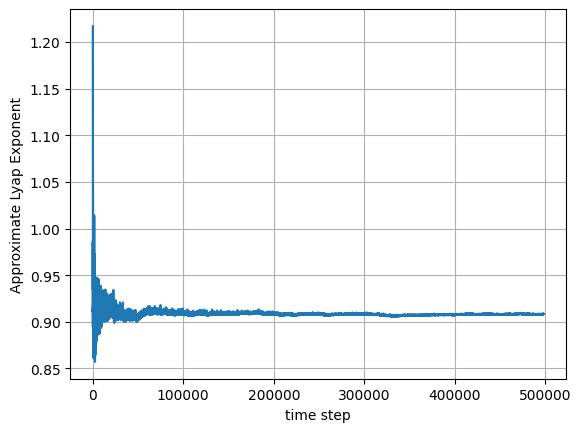

In [22]:
plt.plot(lyapunov_approximation_trj[2000:])
plt.grid()
plt.xlabel("time step")
plt.ylabel("Approximate Lyap Exponent")

In [23]:
TRUE_LYAPUNOV_EXPONENT = 0.9056
diff = jnp.abs(lyapunov_approximation_trj - TRUE_LYAPUNOV_EXPONENT)

Text(0, 0.5, 'Absolute error from the true Lyap Exponent')

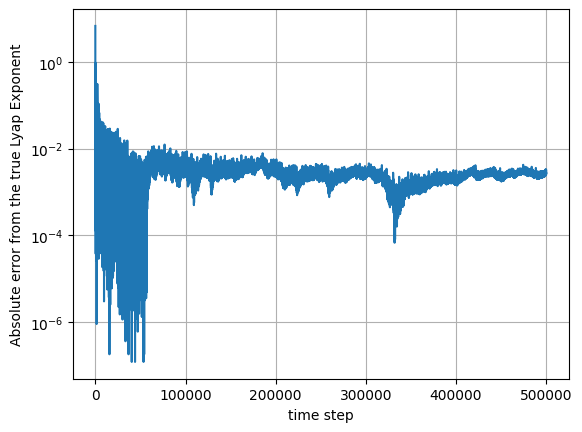

In [24]:
plt.semilogy(diff)
plt.grid()
plt.xlabel("time step")
plt.ylabel("Absolute error from the true Lyap Exponent")